In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

c:\Users\jwbar\OneDrive\Not School\Documents\Programming+Raspberry Pi\ML\Geron 3rd ed\env\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
print(mnist["target"])
X,y = mnist.data, mnist.target

['5' '0' '4' ... '4' '5' '6']


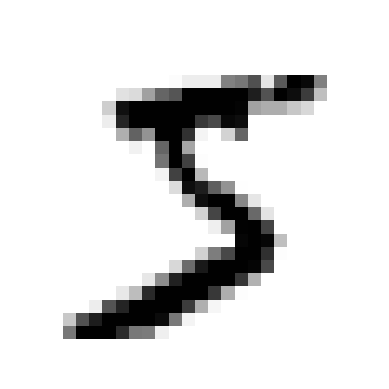

In [4]:
def plot_digit(data):
    img = data.reshape(28,28)
    plt.imshow(img, cmap="binary")
    plt.axis("off")

plot_digit(X[0])

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


# Binary Classifier

Aim to distinguish the number 5

In [6]:
# target vectors
y_train_5 = (y_train=="5")
y_test_5 = (y_test=="5")

In [7]:
# stochastic gradient descent

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [8]:
sgd_clf.predict([X_train[0]])

array([ True])

# Measuring performance of a binary classifier

## Cross-validation

Accuracy is a bad measure, since just guessing randomly can be very effective sometimes:

In [9]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [10]:
# These high numbers are misleading, since 90% of the numbers are not 5 anyway:

from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

False


array([0.90965, 0.90965, 0.90965])

## Confusion matrices

Involves counting the number of times class i is mistakenly classified as class j, using a square matrix to represent all possible combos

In [11]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Format of confusion matrix is actual class on the rows, and predicted class on the columns

So, we have 687 false positives and 1891 false negatives

In [12]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

## Precision and Recall
We can define the precision in terms of the number of false positives ($FP$) and true positives ($TP$)
$$
precision = \frac{TP}{TP+FP}
$$

We also define the recall (since, if a model guesses correctly once, and guesses negative all other times, it would have $TP=1$, $FP=0$ and so a 100% precsision)

$$
recall = \frac{TP}{TP+FN}
$$

When the model estimates a 5, it is correct 84% of the time.
It misses 65% of the fives:

In [13]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


The $F_1$ score is the harmonic mean of the precision and recall (a type of mean weighted towards lower numbers):
$$
F_1 = \frac{2}{\frac{1}{precision}+\frac{1}{recall}}
$$

In [14]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

Precision and recall normally have a tradeoff, and usually we might value one over the other

`SGDClassifier` uses decision scores to decide how to classify. We can change the threshold:

In [15]:
# gives the threshold for the first digit
sgd_clf.decision_function([X_train[0]])

array([2164.22030239])

In [16]:
# getting the scores instead of predictions
y_scores = cross_val_predict(
    sgd_clf, 
    X_train, 
    y_train_5, 
    cv=3, 
    method = "decision_function")

In [17]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

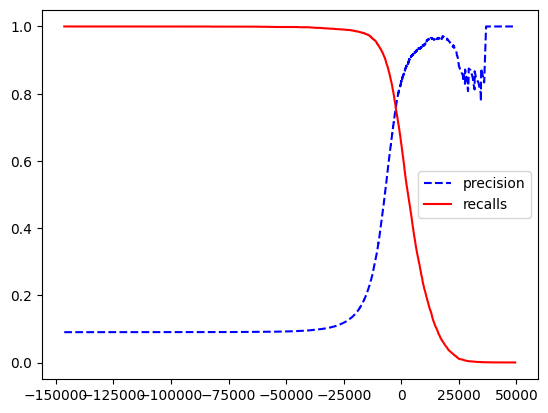

In [18]:
plt.plot(thresholds, precisions[:-1], "b--", label = "precision")
plt.plot(thresholds, recalls[:-1], "r-", label = "recalls")
plt.legend()

Low threshold, everything classified as 5, no false negatives, lots of false positives (90%)

Text(0, 0.5, 'Precision')

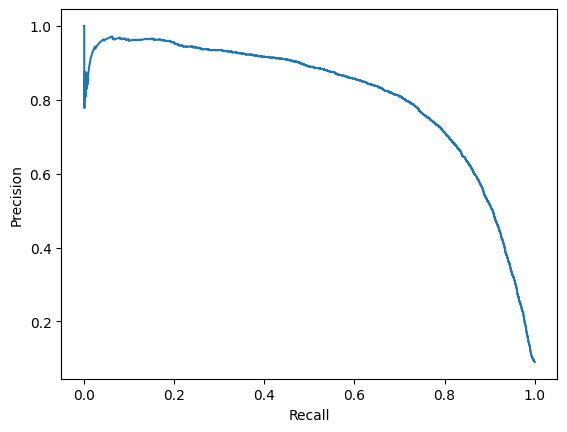

In [19]:
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")

## ROC curve

Plots true positive rate (TPR) (another name for recall) against the false positive rate (FPR)

FPR = fraction of negative instances that are incorrectly classified as positive, = 1 - TNR (true negative rate)

TNR is also called specificity

So, ROC plots sensitivity (recall) versus 1 – specificity

Text(0, 0.5, 'True Positive Rate (Recall)')

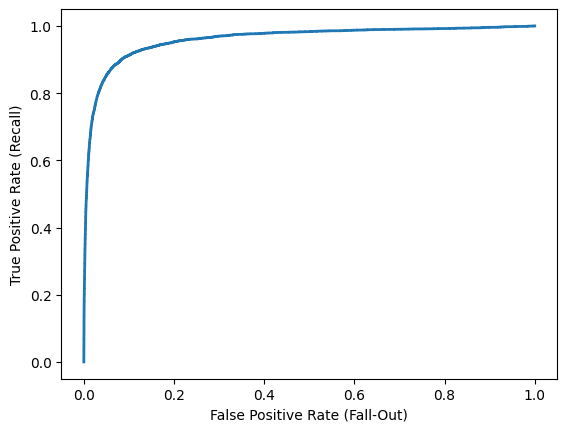

In [20]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

plt.plot(fpr, tpr, linewidth=2)
plt.xlabel("False Positive Rate (Fall-Out)")
plt.ylabel("True Positive Rate (Recall)")


We can compare classifiers using the area under the ROC curve. A perfect classifier has ROC AUC = 1, a random one has ROC AUC = 0.5

In [21]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [23]:
# Compare to a random forest classifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

# RandomForestClassifier has predict_proba() instead of decision_function()
y_probas_forest = cross_val_predict(
    forest_clf, 
    X_train, 
    y_train_5, 
    cv=3,
    method="predict_proba")

y_probas_forest[0]


array([0.11, 0.89])

So, 11% prob first image is negative, 89% it is positive

In [24]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5,
    y_scores_forest)

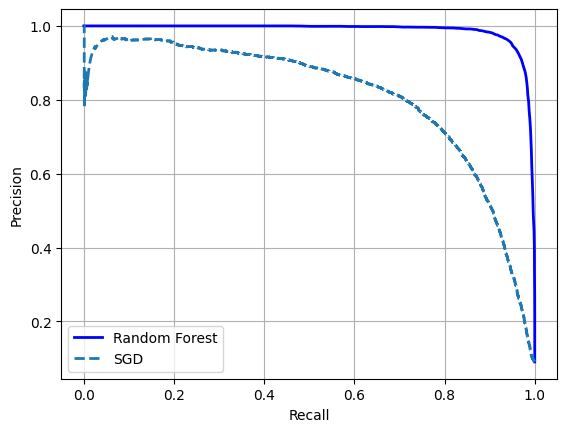

In [27]:
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()

In [30]:
y_pred_forest = y_probas_forest[:, 1] >= 0.5
print(f"F1 Score: {f1_score(y_train_5, y_pred_forest)}")
print(f"ROC AUC Score: {roc_auc_score(y_train_5, y_scores_forest)}")

F1 Score: 0.9274509803921569
ROC AUC Score: 0.9983436731328145


# Multiclass Classifier

Some classifiers natively handle multiple classes

Otherwise, we can use one versus the rest (OvR or OvA) classifiers (train 10 classifiers, one for each number)

Or, we can use one versus one classifiers for each pair (OvO)

OvO is better for algorithms that scale badly for large datasets, since we have lots of smaller models


In [31]:
# SVMs natively support multiclass
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
# only use first 2000 numbers
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [33]:
# scikit-learn uses OvO

svm_clf.predict([X_train[0]])

array(['5'], dtype=object)

In [35]:
svm_clf.decision_function([X_train[0]]).round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [40]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
#cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

# Error Analysis

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

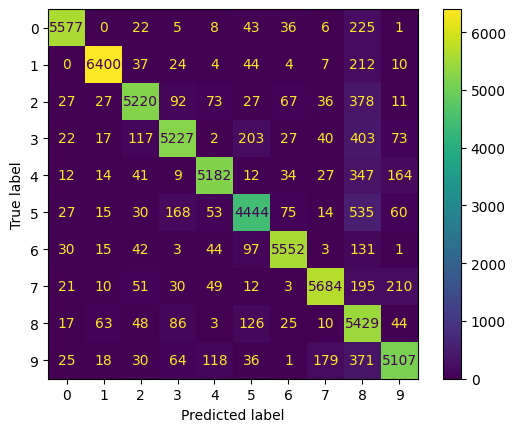

In [46]:
ConfusionMatrixDisplay.from_predictions(
    y_train, 
    y_train_pred)

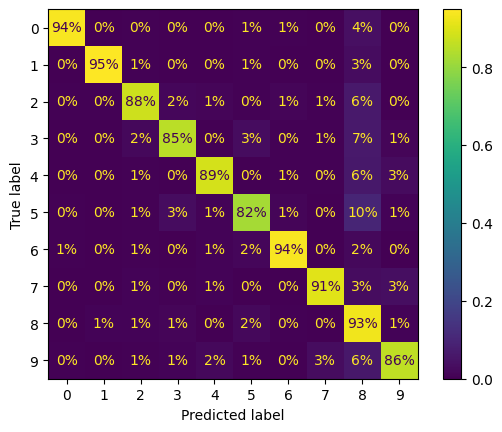

In [45]:
ConfusionMatrixDisplay.from_predictions(
    y_train, 
    y_train_pred,
    normalize="true", # important to normalize, since set may have different amounts of each number 
    values_format=".0%")

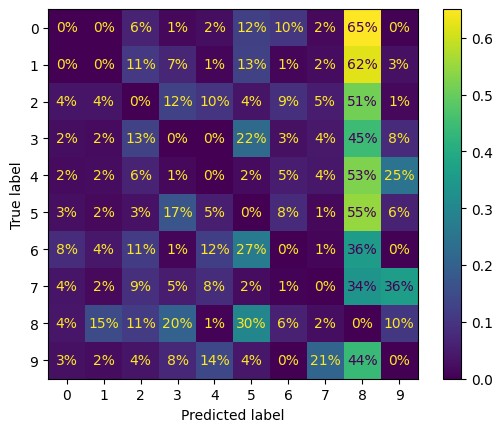

In [47]:
# we can also put 0 weight on correct predictions, and only look at errors:

sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(
    y_train, 
    y_train_pred,
    sample_weight=sample_weight,
    normalize="true", 
    values_format=".0%")

# Exercises

## 1
Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the `KNeighborsClassifier` works quite well for this task; you just need to find good hyperparameter values (try a grid search on the `weights` and `n_neighbors` hyperparameters).

In [57]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


knn_clf = KNeighborsClassifier()

param_grid = [
    {"n_neighbors": [2,3,4,5,6,7],
     "weights": ["uniform", "distance"]}
]

grid_search = GridSearchCV(
    knn_clf,
    param_grid,
    cv=3
)

grid_search.fit(X_train[:10000], y_train[:10000])

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [2, 3, 4, 5, 6, 7],
                          'weights': ['uniform', 'distance']}])

In [58]:
# now fit this on the whole set

grid_search.best_estimator_.fit(X_train, y_train)

grid_search.score(X_test, y_test)

0.9714

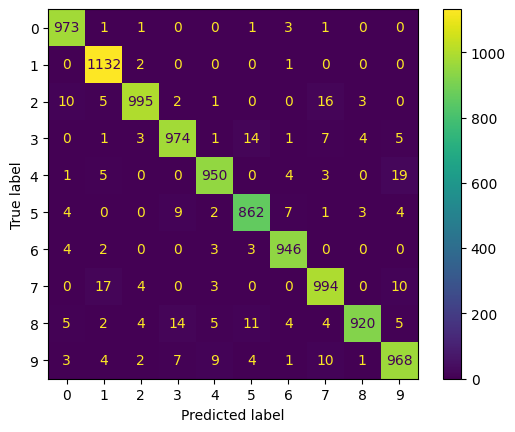

In [60]:
# knn_y_pred = grid_search.best_estimator_.predict(X_train)
test_y_pred = grid_search.best_estimator_.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, test_y_pred)

## 2. Data augmentation

Exercise: _Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. You can use the `shift()` function from the `scipy.ndimage` module. For example, `shift(image, [2, 1], cval=0)` shifts the image two pixels down and one pixel to the right. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called _data augmentation_ or _training set expansion_._

In [64]:
import scipy.ndimage

def shift_image(image, dx, dy):
    image = image.reshape((28, 28)) # get long list of pixels into 28x28 grid
    shifted_image = scipy.ndimage.shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1]) # return to long list


numpy.ndarray

In [76]:
shifts = [(1,0), (-1,0), (0,1), (0,-1)]
X_train_shifted = [image for image in X_train]
y_train_shifted = [label for label in y_train]


for img, label in zip(X_train, y_train):
    for dx, dy in shifts:
        X_train_shifted.append(shift_image(img, dx, dy))
        y_train_shifted.append(label)

X_train_shifted = np.array(X_train_shifted)
y_train_shifted = np.array(y_train_shifted)


In [77]:
knn_model = grid_search.best_estimator_

knn_model.fit(X_train_shifted, y_train_shifted)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [78]:
knn_model.score(X_test, y_test)

0.9763

## 3. Titanic

Exercise: _Tackle the Titanic dataset. A great place to start is on [Kaggle](https://www.kaggle.com/c/titanic). Alternatively, you can download the data from https://homl.info/titanic.tgz and unzip this tarball like you did for the housing data in Chapter 2. This will give you two CSV files: _train.csv_ and _test.csv_ which you can load using `pandas.read_csv()`. The goal is to train a classifier that can predict the `Survived` column based on the other columns._

In [85]:
import pandas as pd

titanic_train = pd.read_csv("titanic/train.csv")
titanic_test = pd.read_csv("titanic/test.csv")

In [86]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [87]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [110]:
titanic_train["Sex"].unique()

array(['male', 'female'], dtype=object)

array([[<Axes: xlabel='Age', ylabel='Age'>,
        <Axes: xlabel='Fare', ylabel='Age'>],
       [<Axes: xlabel='Age', ylabel='Fare'>,
        <Axes: xlabel='Fare', ylabel='Fare'>]], dtype=object)

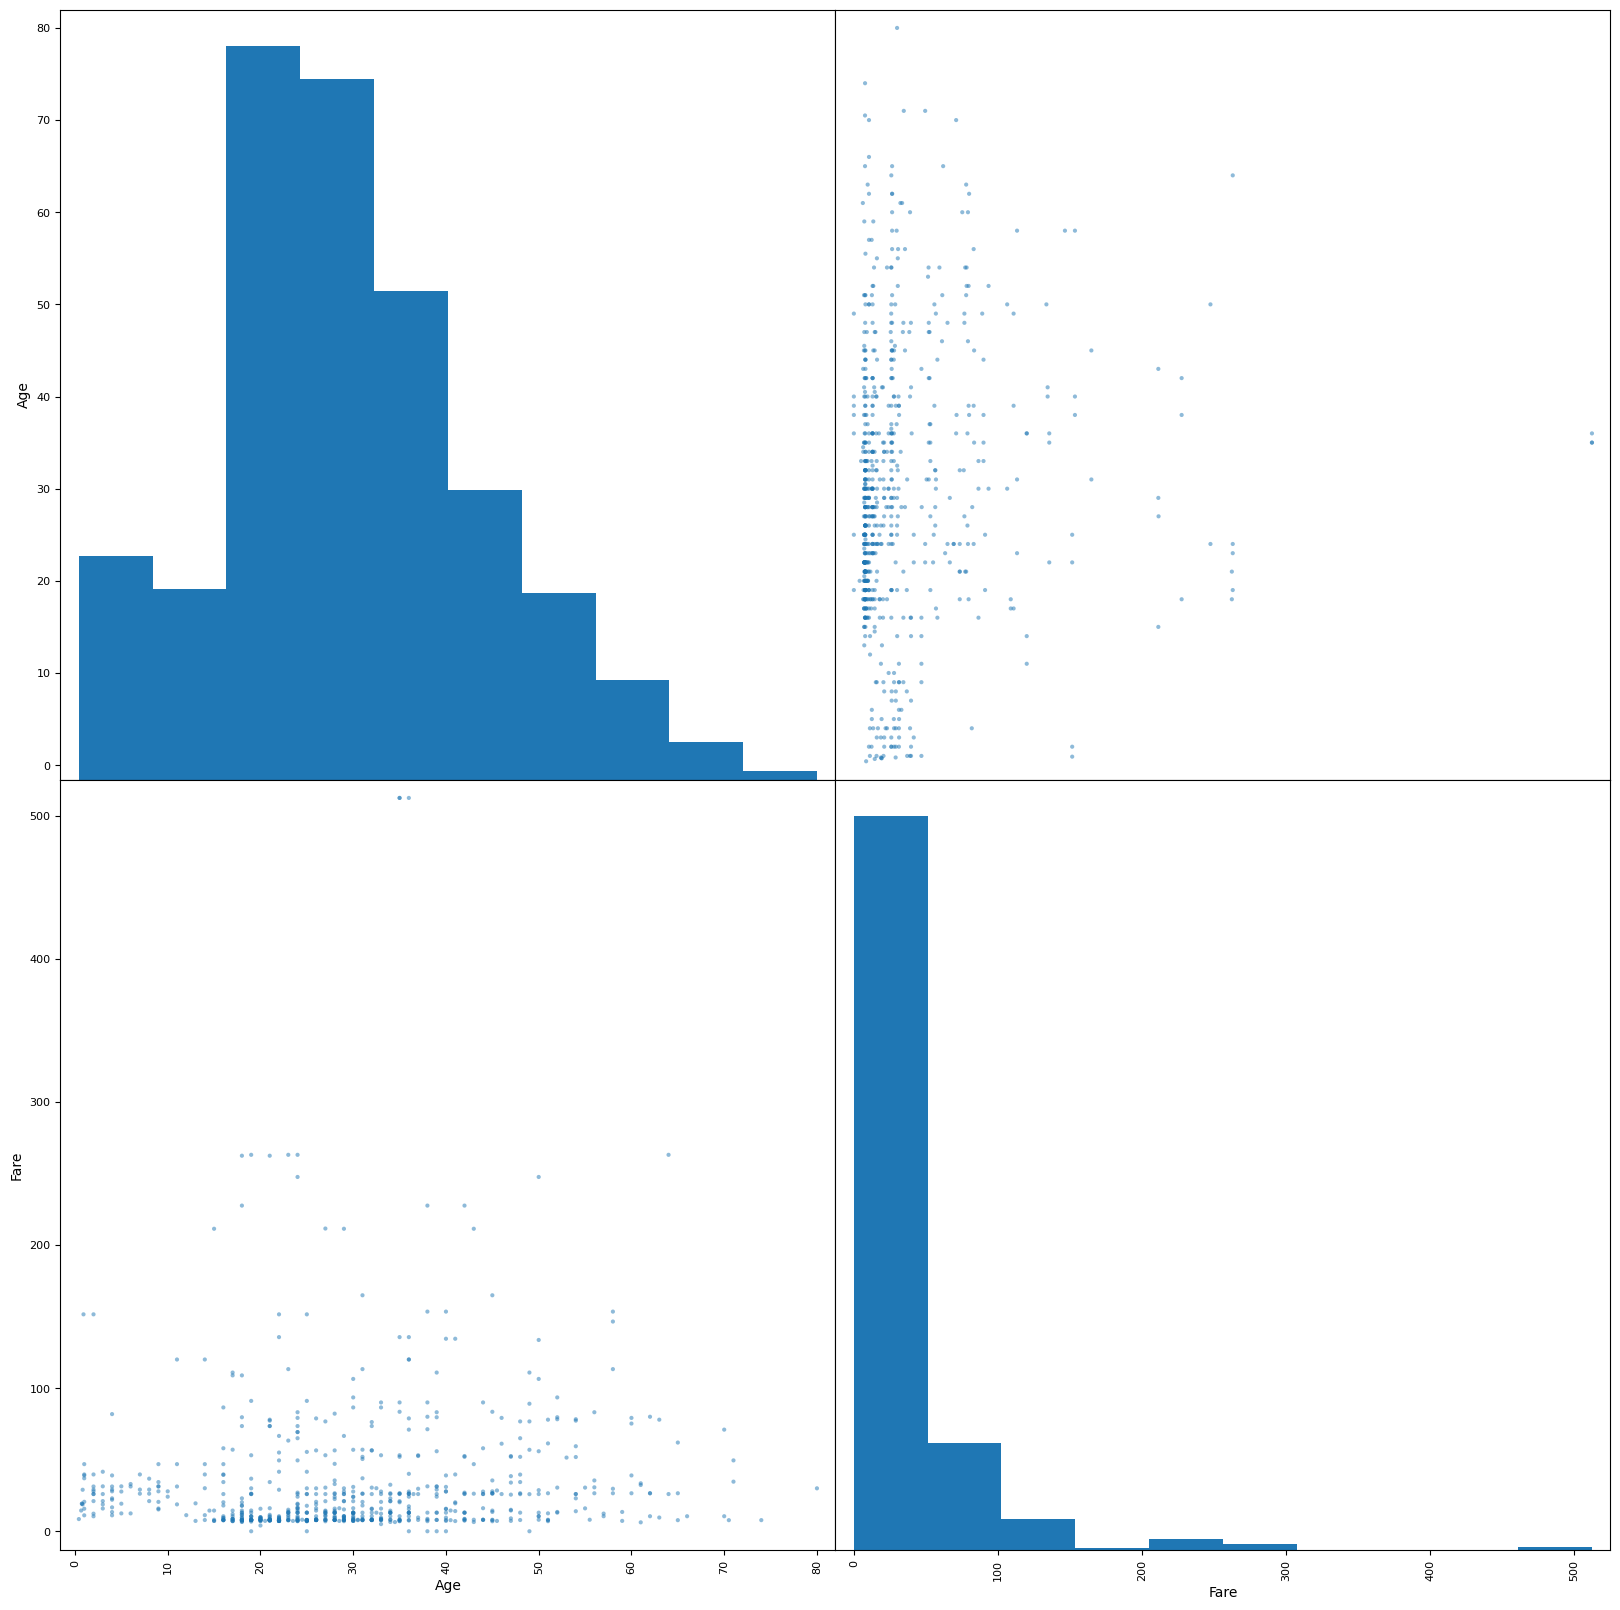

In [88]:
pd.plotting.scatter_matrix(titanic_train.select_dtypes(["float64"]), figsize=(20,20))

In [111]:
# assume name, and ticket has no effect
# cabin is missing a lot of data so ignore that as well

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import make_pipeline

# minmax scaling for PClass and Age
minmax_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    MinMaxScaler()
)

# Standard scaling for Siblings, family members and fare
scaler_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

# encode embarked location as OneHot
embarked_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder()
)

# turns sex into an is-male column
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(drop="if_binary")
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(drop="if_binary")
)

preprocessing = make_column_transformer(
    (minmax_pipeline, ["Pclass", "Age"]),
    (scaler_pipeline, ["SibSp", "Parch", "Fare"]),
    (cat_pipeline, ["Embarked", "Sex"]),
    remainder="drop"
)

In [121]:
X_train = preprocessing.fit_transform(titanic_train)
y_train = titanic_train["Survived"].values

In [113]:
preprocessing.get_feature_names_out()

array(['pipeline-1__Pclass', 'pipeline-1__Age', 'pipeline-2__SibSp',
       'pipeline-2__Parch', 'pipeline-2__Fare', 'pipeline-3__Embarked_C',
       'pipeline-3__Embarked_Q', 'pipeline-3__Embarked_S',
       'pipeline-3__Sex_male'], dtype=object)

In [122]:
# Trying a random forest classifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [123]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8104119850187267

In [124]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8035830212234707

In [126]:
test_data = pd.read_csv("titanic/test.csv")

In [127]:
processed_test_data = preprocessing.fit_transform(test_data)

predictions = forest_clf.predict(processed_test_data)

In [133]:
kaggle_vals = zip(test_data["PassengerId"].values, predictions)

rep = "PassengerId,Survived\n"

for id, pred in zip(test_data["PassengerId"].values, predictions):
    rep += f"{id},{pred}\n"

with open("predictions.csv", "w+") as f:
    f.write(rep)